**Mount Google Drive**

In [1]:
# #Import the drive module for accessing the google drive 
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [1]:
import pandas as pd # Importing the pandas module for reading the data
def load_data():# Function for opening the dataset 
    data =pd.read_csv("/content/drive/MyDrive/Green Travel/Hotel_Reviews.csv")
    return data

In [2]:
reviews_df = load_data() # Call the function 
reviews_df.head(5)# Print the last 2 index data

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [3]:
reviews_df.shape

(515738, 17)

In [4]:
reviews_df['Total_Number_of_Reviews_Reviewer_Has_Given'].sum()

3695779

In [5]:
# append the positive and negative text reviews
reviews_df["review"] = reviews_df["Negative_Review"] + reviews_df["Positive_Review"]
# create the label
reviews_df["is_bad_review"] = reviews_df["Reviewer_Score"].apply(lambda x: 1 if x < 5 else 0)
# select only relevant columns
reviews_df = reviews_df[["review", "is_bad_review"]]
reviews_df.head()

,review,is_bad_review
0,I am so angry that i made this post available...,1
1,No Negative No real complaints the hotel was g...,0
2,Rooms are nice but for elderly a bit difficul...,0
3,My room was dirty and I was afraid to walk ba...,1
4,You When I booked with your company on line y...,0


**Sample Data**

In [6]:
reviews_df = reviews_df.sample(frac = 0.1, replace = False, random_state=42)

Pandas sample() is used to generate a sample random row or column from the function caller data frame.

Syntax:

DataFrame.sample(n=None, frac=None, replace=False, weights=None, random_state=None, axis=None)


n: int value, Number of random rows to generate.

frac: Float value, Returns (float value * length of data frame values ). 
frac cannot be used with n.
replace: Boolean value, return sample with replacement if True.

random_state: int value or numpy.random.RandomState, optional.

if set to a particular integer, will return same rows as sample in every iteration.

axis: 0 or ‘row’ for Rows and 1 or ‘column’ for Columns.

**Clean data**

In [7]:
# remove 'No Negative' or 'No Positive' from text
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

If the user doesn't leave any negative feedback comment, this will appear as "No Negative" in our data. This is the same for the positive comments with the default value "No Positive". We have to remove those parts from our texts.

In [8]:
from nltk.corpus import wordnet
import nltk 
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


To clean textual data, we call our custom 'clean_text' function that performs several transformations:<br>

* lower the text <br>
* tokenize the text (split the text into words) and remove the punctuation <br>
* remove useless words that contain numbers <br>
* remove useless stop words like 'the', 'a' ,'this' etc.<br>
* Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database <br>

* lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep) 
Now that we have cleaned our data, we can do some feature engineering for our modelization part.

**Feature Engineering**

In [9]:
# add sentiment anaylsis columns
import nltk 
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


We first start by adding sentiment analysis features because we can guess that customers reviews are highly linked to how they felt about their stay at the hotel. We use Vader, which is a part of the NLTK module designed for sentiment analysis. Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into accout the context of the sentences to determine the sentiment scores. For each text, Vader retuns 4 values:

* a neutrality score
* a positivity score
* a negativity score
* an overall score that summarizes the previous scores.

We will integrate those 4 values as features in our dataset.

Feature engineering is the process of transforming raw data into features that better represent the 
underlying problem to the predictive models, resulting in improved model accuracy on unseen data.

In [10]:
# add number of characters column
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# add number of words column
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

Next, we add some simple metrics for every text:

* number of characters in the text
* number of words in the text

In [11]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]
# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

The next step consist in extracting vector representations for every review. The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What's interesting is that similar words will have similar representation vectors.

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

We first have to train a Doc2Vec model by feeding in our text data. By applying this model on our reviews, we can get those representation vectors.

In [12]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

Finally we add the TF-IDF (Term Frequency - Inverse Document Frequency) values for every word and every document.

But why not simply counting how many times each word appears in every document? The problem with this method is that it doesn't take into account the relative importance of words in the texts. A word that appears in almost every text would not likely bring useful information for analysis. On the contrary, rare words may have a lot more of meanings.

The TF-IDF metric solves this problem:

TF computes the classic number of times the word appears in the text
IDF computes the relative importance of this word which depends on how many texts the word can be found
We add TF-IDF columns for every word that appear in at least 10 different texts to filter some of them and reduce the size of the final output.

**Exploratory data analysis**

In [13]:
# show is_bad_review distribution
reviews_df["is_bad_review"].value_counts(normalize = True)

0    0.956761
1    0.043239
Name: is_bad_review, dtype: float64

Our dataset is highly imbalanced because less than 5% of our reviews are considered as negative ones. This information will be very useful for the modelling part.

Now let's print some wordclouds to have a glimpse at what kind of words apear in our reviews:

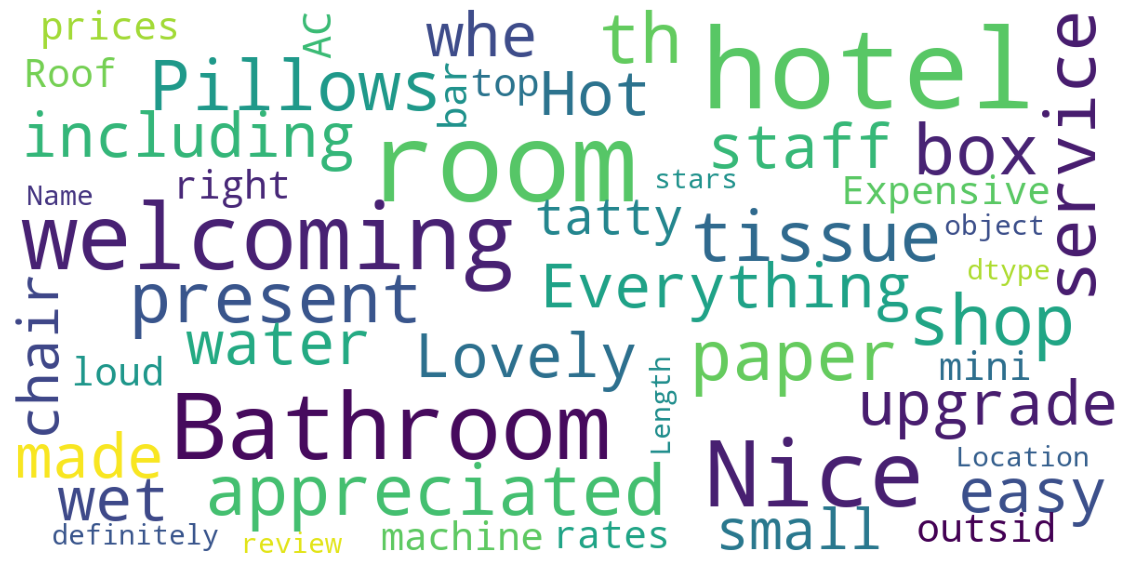

In [14]:
# wordcloud function

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(reviews_df["review"])

Most of the words are indeed related to the hotels: room, staff, breakfast, etc. Some words are more related to the customer experience with the hotel stay: perfect, loved, expensive, dislike, etc.

**Highest positive sentiment reviews (with more than 5 words)**

In [15]:
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

,review,pos
43101,A perfect location comfortable great value,0.931
211742,Clean comfortable lovely staff,0.907
175551,Friendly welcome Comfortable room,0.905
365085,Good location great value,0.904
109564,Clean friendly and comfortable,0.902
145743,Good value amazing location,0.901
407590,breakfast excellent Clean comfort,0.899
407546,Great place I enjoyed,0.881
218571,Beautiful Quirky Comfortable,0.878
436901,Lovely comfortable rooms,0.877


The most positive reviews indeed correspond to some good feedbacks.

**Lowest negative sentiment reviews (with more than 5 words)**

In [16]:
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

,review,neg
193086,No dislikes LOCATION,0.831
356368,Nothing Great helpful wonderful staff,0.812
318516,A disaster Nothing,0.804
458794,Nothing Excellent friendly helpful staff,0.799
29666,A bit noisy No,0.796
426057,Dirty hotel Smells bad,0.762
263187,Very bad service No,0.758
443796,Nothing perfect,0.750
181508,Window blind was broken,0.744
175316,Nothing Super friendly staff,0.743


Some errors can be found among the most negative reviews: Vader sometimes interpret 'no' or 'nothing' as negative words whereas they are sometimes used to say that there were no problems with the hotel. Fortunately, most of the reviews are indeed bad ones.

**Plot sentiment distribution for positive and negative reviews**

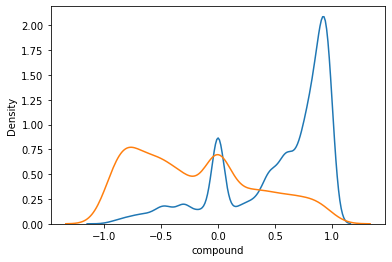

In [17]:
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

for x in [0, 1]:
    subset = reviews_df[reviews_df['is_bad_review'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

The above graph shows the distribution of the reviews sentiments among good reviews and bad ones. We can see that good reviews are for most of them considered as very positive by Vader. On the contrary, bad reviews tend to have lower compound sentiment scores.

This shows us that previously computed sentiment features will be very important in our modelling part.

**Modelling reviewer_score**

In [18]:
# feature selection
label = "is_bad_review"
ignore_cols = [label, "review", "review_clean"]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

We first choose which features we want to use to train our model. Then we split our data into two parts:

* one to train our model
* one to assess its performances

We will next use a Random Forest (RF) classifier for our predictions.

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier

import sklearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import svm

**Train a random forest classifier**

In [ ]:
# rf = RandomForestClassifier(n_estimators = 100, random_state = 42)
# rf.fit(X_train, y_train)

In [ ]:
# predictions = rf.predict(X_test)
# print('Classification Report of RF:\n',classification_report(y_test, predictions))
# print('Confusion Matrix:\n',confusion_matrix(y_test, predictions))
# print('Accuracy Score:',accuracy_score(y_test, predictions))
# print("Precision:",metrics.precision_score(y_test, predictions))
# print("Recall:",metrics.recall_score(y_test,predictions ))

**Train with Naive Bayes Classifier (GaussianNB)**

In [ ]:
# from sklearn.naive_bayes import GaussianNB
# model=GaussianNB()
# model.fit(X_train,y_train)
# predictions_gnb = model.predict(X_test)
# predictions = model.predict(X_test)
# print('Classification Report of Naive Bayes: GaussianNB:\n',classification_report(y_test, predictions_gnb))
# print('Confusion Matrix:\n',confusion_matrix(y_test, predictions_gnb))
# print('Accuracy Score:',accuracy_score(y_test, predictions_gnb))
# print("Precision:",metrics.precision_score(y_test, predictions_gnb))
# print("Recall:",metrics.recall_score(y_test,predictions_gnb ))

In [20]:
# # KNN  Algo
# knn_classifier = KNeighborsClassifier()
# knn_classifier.fit(X_train,y_train)
# y_pred_knn_classifier = knn_classifier.predict(X_test)
# print("KNN  Algorihm")
# print(classification_report(y_test, y_pred_knn_classifier))

# # Decission Tree Classifier 
# decession_tree = DecisionTreeClassifier()
# decession_tree.fit(X_train,y_train)
# y_pred_decession_tree = decession_tree.predict(X_test)
# print("Decission Tree Classifier")
# print(classification_report(y_test, y_pred_decession_tree))

# Gradient bossting
gradient_bossting = GradientBoostingClassifier(random_state=3)
gradient_bossting.fit(X_train,y_train)
y_pred_gradientbossting = gradient_bossting.predict(X_test)
print("GradientBosting  Algorithm")
print(classification_report(y_test, y_pred_gradientbossting))

# Logistic Regressor
logis_reg =LogisticRegression()
logis_reg.fit(X_train,y_train)
y_pred_log = logis_reg.predict(X_test)
print("Logistic Reg  Algorithm")
print(classification_report(y_test, y_pred_log))

GradientBosting  Algorithm
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9864
           1       0.59      0.14      0.22       451

    accuracy                           0.96     10315
   macro avg       0.78      0.57      0.60     10315
weighted avg       0.95      0.96      0.95     10315

Logistic Reg  Algorithm
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      9864
           1       0.54      0.08      0.15       451

    accuracy                           0.96     10315
   macro avg       0.75      0.54      0.56     10315
weighted avg       0.94      0.96      0.94     10315



Passive Aggressive Classifier Algorithm

In [ ]:
# # PAC 
# from sklearn.linear_model import PassiveAggressiveClassifier
# from sklearn import metrics
# linear_clf = PassiveAggressiveClassifier(max_iter=1000, random_state=0,tol=1e-3)

# linear_clf.fit(X_train, y_train)
# pred = linear_clf.predict(X_test)
# score = metrics.accuracy_score(y_test, pred)

# pac_predictions = linear_clf.predict(X_test)
# print('Classification Report:\n',classification_report(y_test, pac_predictions))

# print('Confusion Matrix:\n',confusion_matrix(y_test, pac_predictions))
# print('Accuracy Score:',accuracy_score(y_test, pac_predictions))
# print("Precision:",metrics.precision_score(y_test, pac_predictions))
# print("Recall:",metrics.recall_score(y_test,pac_predictions ))


In [ ]:
from sklearn import svm
# clf = svm.SVC(kernel='linear')
# clf.fit(X_train,y_train) 
# pred=clf.predict(X_test)
# print(classification_report(y_test, pred))
# print('\nAccuracy: {0:.4f}'.format(accuracy_score(y_test, pred)))
# print(confusion_matrix(y_test,pred))

In [ ]:
pip install funcsigs

**ROC CURVE for Logistic Regression**

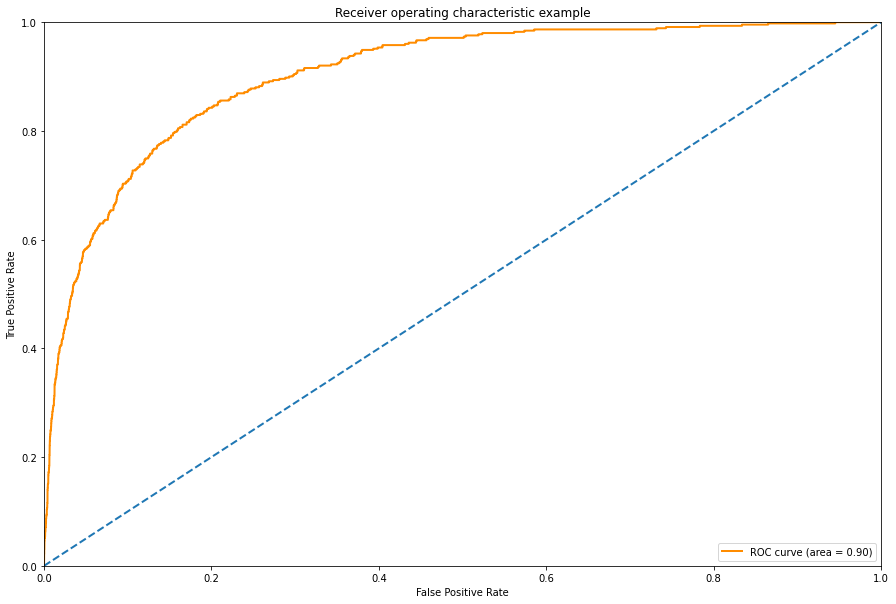

In [ ]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in logis_reg.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The ROC (Receiver Operating Characteristic) curve is usually a good graph to summarize the quality of our classifier. The higher the curve is above the diagonal baseline, the better the predictions. Although the AUC ROC (Area Under the Curve ROC) is very good, we should not use here the ROC curve to assess the quality of our model.

Why? First let us remind the False Positive Rate formula, which corresponds to the x axis of the ROC curve: FPR (False Positive Rate) = # False Positives / # Negatives.

Here the # Negatives corresponds to our number of good reviews which is very high because our dataset is imbalanced. This means that even with some False Positives, our FPR will tend to stay very low. Our model will be able to make a lot of false positives predictions and still have a low false positive rate, while increasing the true positive rate and therefore artificially increasing the AUC ROC metric.

**PR CURVE**

Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.40')

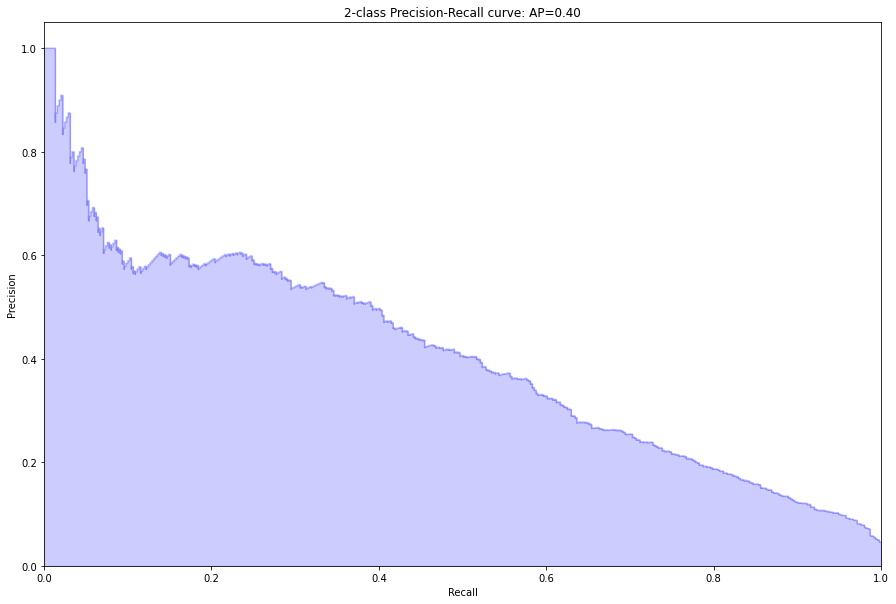

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve
from funcsigs import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

A better metric in this imbalanced situation is the AUC PR (Area Under the Curve Precision Recall), or also called AP (Average Precision).

We can see that the precision decreases when we increase the recall. This shows us that we have to choose a prediction thresold adapted to our needs. If our goal is to have a high recall, we should set a low prediction thresold that will allow us to detect most of the observations of the positive class, but with a low precision. On the contrary, if we want to be really confident about our predictions but don't mind about not finding all the positive observations, we should set a high thresold that will get us a high precision and a low recall.

In order to know if our model performs better than another classifier, we can simply use the AP metric. To assess the quality of our model, we can compare it to a simple decision baseline. Let's take a random classifier as a baseline here that would predict half of the time 1 and half of the time 0 for the label.

Such a classifier would have a precision of 4.3%, which corresponds to the proportion of positive observations. For every recall value the precision would stay the same, and this would lead us to an AP of 0.043. The AP of our model is approximately 0.35, which is more than 8 times higher than the AP of the random method. This means that our model has a good predictive power.

In [ ]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = logis_reg.predict_proba(reviews_df[features].iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(reviews_df[label].iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

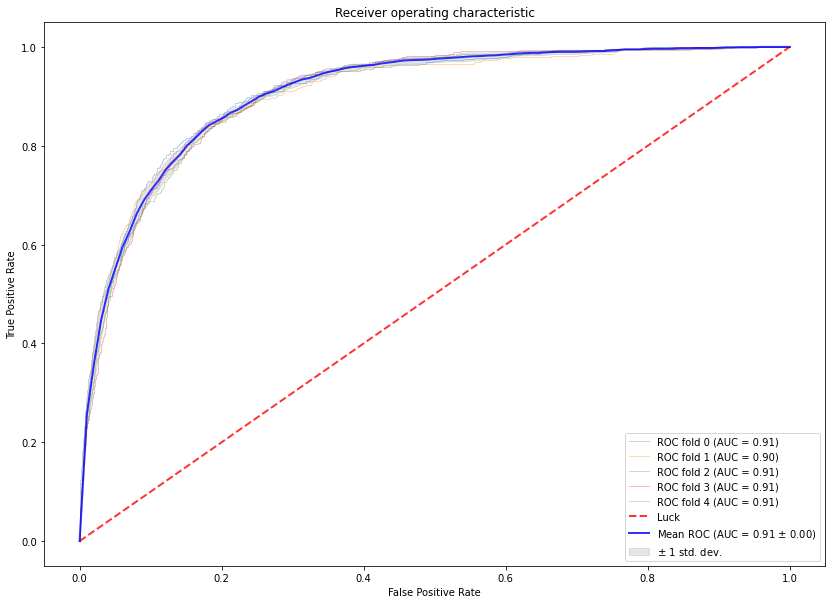

,AUC Train,AUC Test
0,0.929329,0.910111
1,0.916373,0.904982
2,0.916697,0.905110
3,0.915597,0.905945
4,0.914791,0.908982


In [ ]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(reviews_df[features], reviews_df[label]), range(5)):
    logis_reg.fit(reviews_df[features].iloc[train], reviews_df[label].iloc[train])
    _, _, auc_score_train = compute_roc_auc(train) 
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs);
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])

**Confusion matrix of LR**

In [ ]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,y_pred_log)
cm

array([[9811,   53],
       [ 371,   80]])

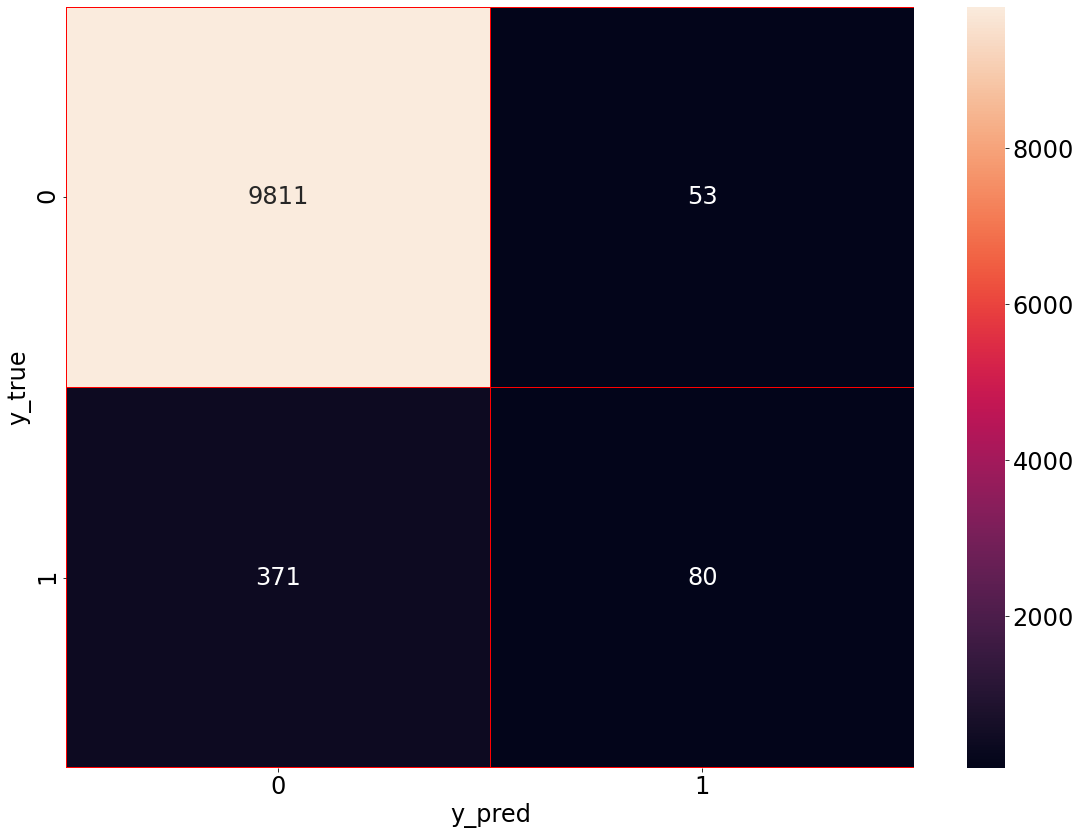

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

f, ax=plt.subplots(figsize=(19,14))
plt.rcParams.update({'font.size': 24})
sns.heatmap(cm,annot=True,linewidths=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.set_cmap('Blues')
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

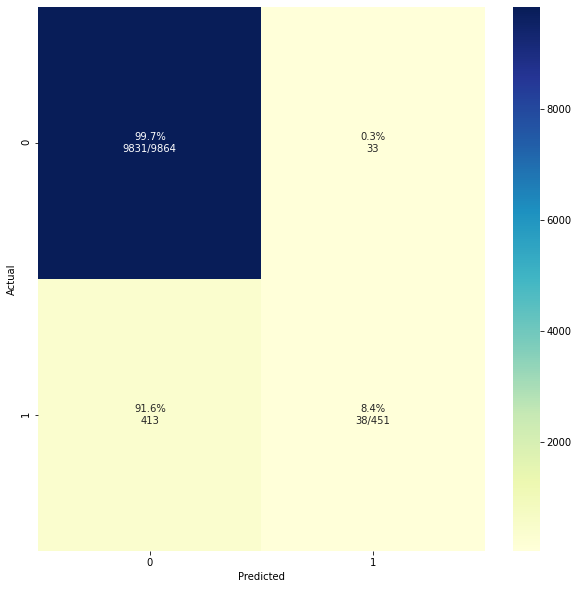

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred_log, figsize=(10,10)):
    cm = confusion_matrix(y_test, y_pred_log, labels=np.unique(y_test))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(y_test, y_pred_log)

In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.6MB 4.9MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=500cde21e4e75e197d9c6722014df23e9042cf4400c5f659839118dd0394f83a
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


**Topic modelling**

In [ ]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim import corpora, models

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
from nltk import FreqDist
import pandas as pd
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

# Import the wordcloud library
from wordcloud import WordCloud